# Modeling COVID-19 Spread and Healthcare Capacity # 

Goal is to predict how many COVID-19 patients they will have to provide in-patient medical care for in the next 3 weeks. This will be achieved by modelling the infection rate. Regions that will not have enough resources to cope with their COVID-19 patients in any given week will be matched to a region that will have a surplus of medical resources that week, so that the burden can be shared and more patients can receive life-saving treatment.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from operator import itemgetter
import operator

In [2]:
os.listdir("./")

['modeling_covics_eindhoven.ipynb',
 'figs',
 'code',
 'nls_R_attempt_all_regions.R',
 '.gitmodules',
 'COVID-19',
 'nls_R_attempt.R',
 '.ipynb_checkpoints',
 'modeling_covics.ipynb',
 'data']

In [3]:
# Load datasets

covid_confirmed = pd.read_csv('/Users/othmanerifki/datascience/projects/covid19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_deaths = pd.read_csv('/Users/othmanerifki/datascience/projects/covid19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_recovered = pd.read_csv('/Users/othmanerifki/datascience/projects/covid19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [4]:
# Load the start of these datasets
covid_confirmed.head()
covid_deaths.head()
covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,2,2,2
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,0,0,0,2,2,2,10,17,17,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,12,32,32,32,65,65,24,65,29,29
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Extract all column names
cols_keys = covid_confirmed.keys()
# Make sure all datasets have the same columns
# Test this code with covid_confirmed = covid_confirmed.drop(['Lat'], axis=1)
lists = [covid_confirmed.keys(), covid_deaths.keys(), covid_recovered.keys()]
it = iter(lists)
the_len = len(cols_keys)
if not all(len(l) == the_len for l in it):
    raise ValueError('not all lists have same length!')

print(f'Total number of days in database: {len(cols_keys)}')

Total number of days in database: 70


In [6]:
# Collect the counts for each date
confirmed = covid_confirmed.loc[:, cols_keys[4]:cols_keys[-1]]
deaths = covid_deaths.loc[:, cols_keys[4]:cols_keys[-1]]
recovered = covid_recovered.loc[:, cols_keys[4]:cols_keys[-1]]
dates = confirmed.keys()

In [7]:
# Calculate totals, rates, and cumulative counts in the world
total_confirmed_global = []
total_deaths_global = []
total_recovered_global = []
mortality_rate_global = []
for d in dates:
    tmp_conf = confirmed[d].sum()
    tmp_deat = deaths[d].sum()
    tmp_reco = recovered[d].sum()
    total_confirmed_global.append(tmp_conf)
    total_deaths_global.append(tmp_deat)
    total_recovered_global.append(tmp_reco)
    mortality_rate_global.append(tmp_deat/tmp_conf)


In [8]:
# convert to numpy arrays
days = np.array([i for i in range(len(dates))]).reshape(-1,1)
total_confirmed_global = np.array(total_confirmed_global).reshape(-1,1)
total_deaths_global = np.array(total_deaths_global).reshape(-1,1)
total_recovered_global = np.array(total_recovered_global).reshape(-1,1)

In [9]:
# Exponential growth
def func(x, a, b):
    return a * np.exp(b * x) 
# Fit - but not working
#days2 = np.array([i for i in range(len(dates))]).reshape(1,-1)
#popt, pcov = curve_fit(func, days.ravel(),  total_confirmed.ravel())
#plt.plot(days, total_confirmed, 'b-', days, func(days, *popt), 'g--')
popt = [total_confirmed_global[0],0.1075]

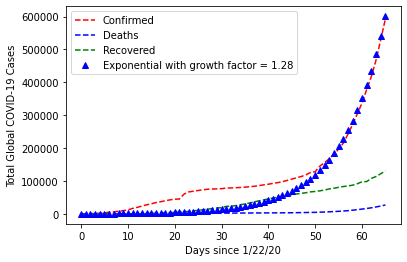

In [10]:
fig, ax = plt.subplots()
ax.plot(days, total_confirmed_global, 'r--', label='Confirmed')
ax.plot(days, total_deaths_global   , 'b--' , label='Deaths')
ax.plot(days, total_recovered_global, 'g--' , label='Recovered')
ax.plot(days, func(days, *popt), 'b^' , label='Exponential with growth factor = %.2f' % 10**popt[1])
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Global COVID-19 Cases')
plt.show()

In [11]:
# Future forcasting for the next 3 weeks
# dates: actual dates
days_in_future = 21
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1) # days count including future forecasting
adjusted_dates = future_forecast[:-days_in_future] # days count up to now


In [12]:
# Convert all integers into datetime 
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start,'%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [13]:
# Latest data
latest_confirmed = covid_confirmed[dates[-1]]
latest_deaths = covid_deaths[dates[-1]]
latest_recovered = covid_recovered[dates[-1]]

In [14]:
# List of unique countries
unique_countries = list(covid_recovered['Country/Region'].unique())

In [15]:
# Total number of cases by each country
total_confirmed_by_country = []
total_deaths_by_country = []
total_recovered_by_country = []
mortality_rate_by_country = []
no_cases = []

for i in unique_countries:
    cases_confirmed = latest_confirmed[covid_confirmed['Country/Region']==i].sum()
    cases_deaths = latest_deaths[covid_confirmed['Country/Region']==i].sum()
    cases_recovered = latest_recovered[covid_confirmed['Country/Region']==i].sum()
    #print(i, len(latest_confirmed[covid_confirmed['Country/Region']==i]))
    if cases_confirmed > 0:
        total_confirmed_by_country.append(cases_confirmed)
    else:
        no_cases.append(i)
    if cases_deaths > 0:
        total_deaths_by_country.append(cases_deaths)
    if cases_recovered > 0:
        total_recovered_by_country.append(cases_recovered)

for i in no_cases:
    unique_countries.remove(i)
# Sort based on the number of cases
unique_countries = [k for k,v in sorted(zip(unique_countries, total_confirmed_by_country), key=operator.itemgetter(1), reverse=True) ]
for i in range(len(unique_countries)):
    total_confirmed_by_country[i] = latest_confirmed[covid_confirmed['Country/Region']==unique_countries[i]].sum()

In [16]:
# Print number of cases per country/area
print('Confirmed cases by Countries/Regions')
for i in range(len(unique_countries[:10])):
    print(f'{unique_countries[i]}: {total_confirmed_by_country[i]} cases' )

Confirmed cases by Countries/Regions
US: 101657 cases
Italy: 86498 cases
China: 81897 cases
Spain: 65719 cases
Germany: 50871 cases
France: 33402 cases
Iran: 32332 cases
United Kingdom: 14745 cases
Switzerland: 12928 cases
Korea, South: 9332 cases


In [17]:
# List of unique province/state
unique_provinces = list(covid_recovered['Province/State'].unique())


## Step one - Analysis of provinces in China
The first step is to understand how well the 3-parameter logistic growth curve model predicts cases in different provinces in China (Ahuja and Nash, 1967)  
𝔼(𝑌𝑡) = 𝑀/(1 + exp(−𝛽(𝑡 − 𝛼))

In [18]:
import numpy as np
import scipy.stats as spst
from scipy.optimize import leastsq
    
# create NLS class
class NLS:
    ''' This provides a wrapper for scipy.optimize.leastsq to get the relevant output for nonlinear least squares.
    Although scipy provides curve_fit for that reason, curve_fit only returns parameter estimates and covariances. 
    This wrapper returns numerous statistics and diagnostics'''
 
    def __init__(self, func, p0, xdata, ydata):
        # Check the data
        if len(xdata) != len(ydata):
            msg = 'The number of observations does not match the number of rows for the predictors'
            raise ValueError(msg)
 
        # Check parameter estimates
        if type(p0) != dict:
            msg = "Initial parameter estimates (p0) must be a dictionry of form p0={'a':1, 'b':2, etc}"
            raise ValueError(msg)
 
        self.func = func
        self.inits = p0.values()
        self.xdata = xdata
        self.ydata = ydata
        self.nobs = len( ydata )
        self.nparm= len( self.inits )
 
        self.parmNames = list(p0.keys())
 
        for i in range( len(self.parmNames) ):
            if len(self.parmNames[i]) > 5:
                self.parmNames[i] = self.parmNames[i][0:4]
 
        # Run the model
        self.mod1 = leastsq(self.func, self.inits, args = (self.xdata, self.ydata), full_output=1)
 
        # Get the parameters
        self.parmEsts = np.round( self.mod1[0], 4 )
 
        # Get the Error variance and standard deviation
        self.RSS = np.sum( self.mod1[2]['fvec']**2 )
        self.df = self.nobs - self.nparm
        self.MSE = self.RSS / self.df
        self.RMSE = np.sqrt( self.MSE )
 
        # Get the covariance matrix
        self.cov = self.MSE * self.mod1[1]
 
        # Get parameter standard errors
        self.parmSE = np.diag( np.sqrt( self.cov ) )
 
        # Calculate the t-values
        self.tvals = self.parmEsts/self.parmSE
 
        # Get p-values
        self.pvals = (1 - spst.t.cdf( np.abs(self.tvals), self.df))*2
 
        # Get biased variance (MLE) and calculate log-likehood
        self.s2b = self.RSS / self.nobs
        self.logLik = -self.nobs/2 * np.log(2*np.pi) - self.nobs/2 * np.log(self.s2b) - 1/(2*self.s2b) * self.RSS
 
        del(self.mod1)
        del(self.s2b)
        del(self.inits)
 
    # Get AIC. Add 1 to the df to account for estimation of standard error
    def AIC(self, k=2):
        return-2*self.logLik + k*(self.nparm + 1)
 
    del(np)
    del(leastsq)
 
    # Print the summary
    def summary(self):
        print ()
        print ('Non-linear least squares')
        print ('Model: ' + self.func.func_name)
        print ('Parameters:')
        print (" Estimate Std. Error t-value P(>|t|)")
        for i in range( len(self.parmNames) ):
                print ("% -5s % 5.4f % 5.4f % 5.4f % 5.4f" % tuple( [self.parmNames[i], self.parmEsts[i], self.parmSE[i], self.tvals[i], self.pvals[i]] ))
        print ()
        print ('Residual Standard Error: % 5.4f' % self.RMSE)
        print ('Df: %i' % self.df)

NameError: name 'np' is not defined

In [ ]:
# prepare data for modeling
all_china = covid_confirmed[covid_confirmed['Country/Region']=='China']
all_china.head()

In [ ]:
# how many days?
cols_keys = all_china.keys()
print(len(cols_keys)-4) # 66 days

In [ ]:
# create df with cumulative number of cases, per region, per day
regions = all_china['Province/State'].tolist()

cumulative_confirmed_china = pd.DataFrame()
for index,row in all_china.iterrows():
    row2 = pd.DataFrame(row).T
    cuml = row2.loc[:, cols_keys[4]:cols_keys[-1]].cumsum()
    cumulative_confirmed_china = cumulative_confirmed_china.append(cuml)
    
# merge with province etc. information
metadata = all_china[['Province/State','Country/Region','Lat','Long']]
cumulative_confirmed_china_annot = pd.concat([metadata, cumulative_confirmed_china], axis=1)

In [ ]:
# let's plot one region just to see the curve
anhui = cumulative_confirmed_china_annot.head(1)
anhui_cases = anhui.loc[:, cols_keys[4]:cols_keys[-1]]
anhui_cases = np.array(anhui_cases).reshape(-1,1)
fig, ax = plt.subplots()
ax.plot(days, anhui_cases, 'r--', label='Confirmed')
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Anhui, China COVID-19 Cases')
plt.show()

In [ ]:
# execute NLS with Anhui, test 
data = anhui.loc[:, cols_keys[4]:cols_keys[-1]].T
data['days'] = list(range(0,len(data)))
data.columns=['cases','days']
  
# First, define the likelihood null model
def nullMod(params, t, yObs):
    M = params[0]
    beta = params[1]
    alpha = params[2]
 
    yHat = M/(1+np.exp(-beta*(t-alpha)))
    err = yObs - yHat
    return(err)
 
p0 = {'M':993, 'beta':0.28, 'alpha':13.3}
 
#tMod = NLS(nullMod, p0, respData['UrchinMass'], respData['respDaily'] )
tMod = NLS(nullMod, p0, data['days'], data['cases'] )

tMod.summary()
 
tMod.AIC()
 
tMod.logLik